In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

## Try TPU

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv
/kaggle/input/glove840b300dtxt/glove.840B.300d.txt
/kaggle/input/sentimenttweet140/shrink_tweet.csv


## Read Dataset

In [3]:
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv",encoding="latin-1",header=None)


In [5]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_name', 'tweet']
df = df.drop(['id', 'date', 'query', 'user_name'], axis=1)
df.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [6]:
# dataset is balanced
df['sentiment'].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

## Reduce size of positive and negative to 20000 

In [7]:
negative_counter = 0
positive_counter = 0
drop_indices = []
for index, row in df.iterrows():
    if (row['sentiment'] == 0) and (negative_counter > 19999):
        drop_indices.append(index)
        negative_counter += 1
    elif row['sentiment'] == 0:
        negative_counter += 1
    elif (row['sentiment'] == 4) and (positive_counter > 19999):
        drop_indices.append(index)
        positive_counter += 1
    elif row['sentiment'] == 4:
        positive_counter += 1

df = df.drop(drop_indices)

In [8]:
df.to_csv('shrink_tweet.csv', index=False)

In [4]:
df = pd.read_csv('/kaggle/input/sentimenttweet140/shrink_tweet.csv',encoding="latin-1")
df.shape

(40000, 2)

## Preprocessing

In [5]:
import re
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
english_stopwords = stopwords.words('english')
#base of english stopwords
stemmer = SnowballStemmer('english')
#stemming algorithm
regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
#regex for mentions and links in tweets

def preprocess(content, stem=False):
  content = re.sub(regex, ' ', str(content).lower()).strip()
  tokens = []
  for token in content.split():
    if token not in english_stopwords:
      tokens.append(stemmer.stem(token))
  return " ".join(tokens)

df.tweet = df.tweet.apply(lambda x: preprocess(x))

In [7]:
df['tweet'].apply(lambda x:len(str(x).split())).max() # find longest sentence among all tweets

29

## Map 4 to 1

In [8]:
def lamb_func(x):
    
  if x==4:
    return 1
  else:
    return 0


In [9]:
df['sentiment'] = df['sentiment'].apply(lamb_func)

In [10]:
df['sentiment'].value_counts()

0    20000
1    20000
Name: sentiment, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['sentiment'],test_size=0.2,shuffle=True)

## Prepare Embedding Layer

In [12]:
from keras.preprocessing import sequence, text
from tensorflow.keras.preprocessing.sequence import pad_sequences
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 30

token.fit_on_texts(list(X_train))
xtrain_seq = token.texts_to_sequences(list(X_train))
xtest_seq = token.texts_to_sequences(list(X_test))

#zero pad the sequences
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len,padding='post')
xtest_pad = pad_sequences(xtest_seq, maxlen=max_len,padding='post')

word_index = token.word_index
print(len(word_index))

22077


## Train a simple RNN

In [63]:
from tensorflow.keras import losses
# with strategy.scope():
model = keras.Sequential([
    keras.layers.Embedding(len(word_index) + 1,300,input_length=max_len),
#     keras.layers.GlobalAveragePooling1D(),
#     keras.layers.Dropout(0.2),
    keras.layers.SimpleRNN(100),
#     keras.layers.Dropout(0.2),
#     keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(1,activation="sigmoid")
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 30, 300)           6654600   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 100)               40100     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 6,694,801
Trainable params: 6,694,801
Non-trainable params: 0
_________________________________________________________________


In [64]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(xtrain_pad, y_train, epochs=10,validation_data=(xtest_pad,y_test),callbacks=[early_stop])

Epoch 1/20
1000/1000 [==============================] - 42s 40ms/step - loss: 0.6593 - accuracy: 0.6140 - val_loss: 0.6189 - val_accuracy: 0.6775
Epoch 2/20
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5744 - accuracy: 0.7154 - val_loss: 0.6247 - val_accuracy: 0.6721
Epoch 3/20
1000/1000 [==============================] - 23s 23ms/step - loss: 0.5696 - accuracy: 0.7175 - val_loss: 0.6312 - val_accuracy: 0.6611
Epoch 4/20
1000/1000 [==============================] - 23s 23ms/step - loss: 0.5127 - accuracy: 0.7613 - val_loss: 0.6390 - val_accuracy: 0.6743
Epoch 5/20
1000/1000 [==============================] - 23s 23ms/step - loss: 0.4742 - accuracy: 0.7867 - val_loss: 0.6728 - val_accuracy: 0.6658
Epoch 6/20
1000/1000 [==============================] - 23s 23ms/step - loss: 0.4463 - accuracy: 0.8091 - val_loss: 0.6621 - val_accuracy: 0.6758


## Glove Embedding

In [13]:
# load the GloVe vectors in a dictionary:
from tqdm import tqdm
embeddings_index = {}
f = open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196018it [04:07, 8871.58it/s]

Found 2196017 word vectors.


In [14]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 22077/22077 [00:00<00:00, 274032.94it/s]


## LSTM

In [21]:
from tensorflow.keras import losses
# with strategy.scope():
model = keras.Sequential([
    keras.layers.Embedding(len(word_index) + 1,300,weights=[embedding_matrix],input_length=max_len,trainable=False),
    keras.layers.LSTM(100,dropout=0.3, recurrent_dropout=0.3),
#     keras.layers.Dropout(0.2),
    keras.layers.Dense(1,activation="sigmoid")
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           6649800   
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 6,743,305
Trainable params: 93,505
Non-trainable params: 6,649,800
_________________________________________________________________


In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(xtrain_pad, y_train, epochs=10,validation_data=(xtest_pad,y_test),callbacks=[early_stop])

Epoch 1/20
1000/1000 [==============================] - 55s 50ms/step - loss: 0.5860 - accuracy: 0.6899 - val_loss: 0.5287 - val_accuracy: 0.7301
Epoch 2/20
1000/1000 [==============================] - 50s 50ms/step - loss: 0.5428 - accuracy: 0.7285 - val_loss: 0.5248 - val_accuracy: 0.7416
Epoch 3/20
1000/1000 [==============================] - 49s 49ms/step - loss: 0.5230 - accuracy: 0.7420 - val_loss: 0.5145 - val_accuracy: 0.7427
Epoch 4/20
1000/1000 [==============================] - 50s 50ms/step - loss: 0.5058 - accuracy: 0.7533 - val_loss: 0.5041 - val_accuracy: 0.7548
Epoch 5/20
1000/1000 [==============================] - 49s 49ms/step - loss: 0.4951 - accuracy: 0.7611 - val_loss: 0.5077 - val_accuracy: 0.7548
Epoch 6/20
1000/1000 [==============================] - 50s 50ms/step - loss: 0.4808 - accuracy: 0.7677 - val_loss: 0.5044 - val_accuracy: 0.7570
Epoch 7/20
1000/1000 [==============================] - 49s 49ms/step - loss: 0.4703 - accuracy: 0.7740 - val_loss: 0.5123 -

## GRU

In [24]:
from tensorflow.keras import losses
# with strategy.scope():
model = keras.Sequential([
    keras.layers.Embedding(len(word_index) + 1,300,weights=[embedding_matrix],input_length=max_len,trainable=False),
    keras.layers.SpatialDropout1D(0.2),
    keras.layers.GRU(100),
    keras.layers.Dense(1,activation="sigmoid")
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 300)           6662400   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 30, 300)          0         
 lDropout1D)                                                     
                                                                 
 gru_1 (GRU)                 (None, 32)                32064     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,694,497
Trainable params: 32,097
Non-trainable params: 6,662,400
_________________________________________________________________


In [25]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(xtrain_pad, y_train, epochs=10,validation_data=(xtest_pad,y_test),callbacks=[early_stop])

Epoch 1/10
1000/1000 [==============================] - 9s 7ms/step - loss: 0.5987 - accuracy: 0.6639 - val_loss: 0.5249 - val_accuracy: 0.7369
Epoch 2/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5279 - accuracy: 0.7352 - val_loss: 0.5139 - val_accuracy: 0.7436
Epoch 3/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5113 - accuracy: 0.7483 - val_loss: 0.5073 - val_accuracy: 0.7452
Epoch 4/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4974 - accuracy: 0.7592 - val_loss: 0.5112 - val_accuracy: 0.7450
Epoch 5/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4863 - accuracy: 0.7633 - val_loss: 0.5002 - val_accuracy: 0.7565
Epoch 6/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4761 - accuracy: 0.7708 - val_loss: 0.5054 - val_accuracy: 0.7540
Epoch 7/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4668 - accuracy: 0.7777 - val_loss: 0.5116 - val_accuracy:

## Bi-Directional RNN

In [18]:
from tensorflow.keras import losses
# with strategy.scope():
model = keras.Sequential([
    keras.layers.Embedding(len(word_index) + 1,300,weights=[embedding_matrix],input_length=max_len,trainable=False),
    keras.layers.SpatialDropout1D(0.2),
    keras.layers.Bidirectional(keras.layers.LSTM(100, dropout=0.3, recurrent_dropout=0.3)),
    keras.layers.Dense(1,activation="sigmoid")
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 300)           6623400   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 30, 300)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              320800    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 6,944,401
Trainable params: 321,001
Non-trainable params: 6,623,400
_________________________________________________________________


In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(xtrain_pad, y_train, epochs=10,validation_data=(xtest_pad,y_test),callbacks=[early_stop])

Epoch 1/10
1000/1000 [==============================] - 99s 94ms/step - loss: 0.5787 - accuracy: 0.6930 - val_loss: 0.5604 - val_accuracy: 0.7092
Epoch 2/10
1000/1000 [==============================] - 93s 93ms/step - loss: 0.5404 - accuracy: 0.7242 - val_loss: 0.5326 - val_accuracy: 0.7281
Epoch 3/10
1000/1000 [==============================] - 94s 94ms/step - loss: 0.5175 - accuracy: 0.7434 - val_loss: 0.5388 - val_accuracy: 0.7170
Epoch 4/10
1000/1000 [==============================] - 93s 93ms/step - loss: 0.5010 - accuracy: 0.7517 - val_loss: 0.5175 - val_accuracy: 0.7364
Epoch 5/10
1000/1000 [==============================] - 93s 93ms/step - loss: 0.4847 - accuracy: 0.7623 - val_loss: 0.5186 - val_accuracy: 0.7414
Epoch 6/10
1000/1000 [==============================] - 95s 95ms/step - loss: 0.4697 - accuracy: 0.7710 - val_loss: 0.5269 - val_accuracy: 0.7408
Epoch 7/10
1000/1000 [==============================] - 93s 93ms/step - loss: 0.4560 - accuracy: 0.7811 - val_loss: 0.5323 -

## Model Evaluation

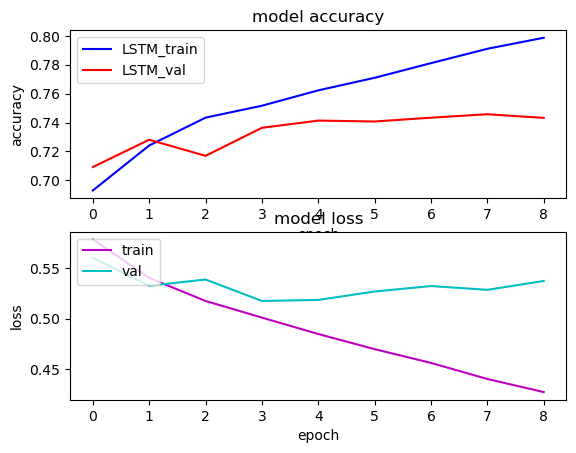

In [20]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')